Model of "Lightning: A Reconfigurable Photonic-Electronic SmartNIC for Fast and
Energy-Efficient Inference ", SIGCOMM  2023
--------------------------------------------------------------------------------
Paper by Zhizhen Zhong, Mingran Yang, Jay Lang, Christian Williams, Liam
Kronman, Alexander Sludds, Homa Esfahanizadeh, Dirk Englund, Manya Ghobadi

This model was created as a final project for the MIT class [6.5930] Hardware
Architecture for Deep Learning by Christos Zarkos, Nikita Lazarev, and Victor
Ion Butoi. The project is titled "KA-CHOW : Accurate Architectural Modeling of
a Photonic SmartNiC Accelerator".

In [1]:
from _tests import scripts
from scripts.notebook_utils import *

In [2]:
ARCH_PATH = "/home/workspace/models/arch/1_macro/lightning_sigc_2023/arch.yaml"

def run_basic_analog_spec(array_rows: int, array_columns: int):
    # Load in the specification
    spec = get_spec("lightning_sigc_2023")

    # Enable the MAX_UTILIZATION variable. This will generate a
    # workload that maximizes the utilization of the array.
    spec.variables["MAX_UTILIZATION"] = True

    # Set the number of rows and columns in the array
    #spec.architecture.find("weight_modulators").attributes.n_instances = 24
    #spec.architecture.find("IMU").spatial.meshX = 1
    #spec.architecture.find("input_modulator").spatial.meshY = array_rows

    return run_mapper(spec, "my_spec")


results = run_basic_analog_spec(array_rows=24, array_columns=24)
print(f"Total Energy (pJ): {results.energy:.2f}")
print(f"Total Area (mm^2): {results.area / 1000000:.2f}")
print(f"Number of MACs: {results.computes:.2f}")
print(f"Compute Density (TOPS/mm^2): {results.tops_per_mm2:.2f}")
print(f"Energy Efficiency (TOPS/W): {results.tops_per_w:.2f}")

Total Energy (pJ): 0.00
Total Area (mm^2): 0.00
Number of MACs: 576.00
Compute Density (TOPS/mm^2): 0.00
Energy Efficiency (TOPS/W): 1.23


In [3]:
display_markdown("# Architectural Diagram")

# Architectural Diagram

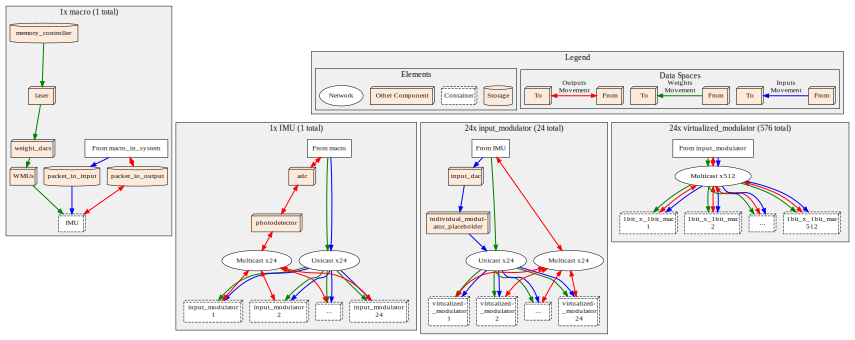

In [4]:
display_diagram(get_diagram("lightning_sigc_2023", ignore=DIAGRAM_DEFAULT_IGNORE))

In [5]:
display_markdown("# Area Breakdown")

# Area Breakdown

In [6]:
import copy
result = run_test("lightning_sigc_2023", "test_area_breakdown")


   This test verifies the area breakdown of the accelerator.
   

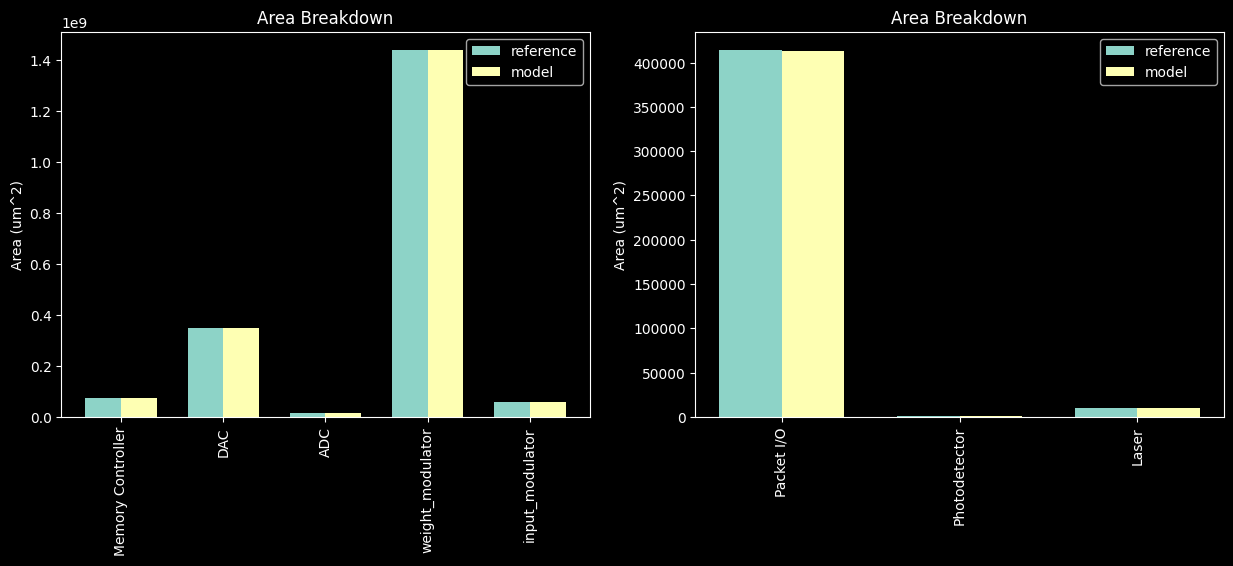

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

big_results = copy.deepcopy(result)
for small_component in ["Laser", "Photodetector", "Packet I/O"]:
    del big_results[0].per_component_area[small_component]

bar_side_by_side(
    big_results[0].get_compare_ref_area(),
    xlabel="",
    ylabel="Area (um^2)",
    title=f"Area Breakdown",
    ax=ax[0],
    # flip_axes=True
)

small_results = copy.deepcopy(result)
for big_component in ["weight_modulator", "input_modulator", "DAC", "ADC", "Memory Controller"]:
    del small_results[0].per_component_area[big_component]

bar_side_by_side(
    small_results[0].get_compare_ref_area(),
    xlabel="",
    ylabel="Area (um^2)",
    title=f"Area Breakdown",
    ax=ax[1],
    # flip_axes=True
)

In [8]:
display_markdown("# Energy Breakdown")

# Energy Breakdown

In [9]:
result = run_test("lightning_sigc_2023", "test_energy_breakdown")


   This test verifies the energy breakdown of the accelerator.
   

100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


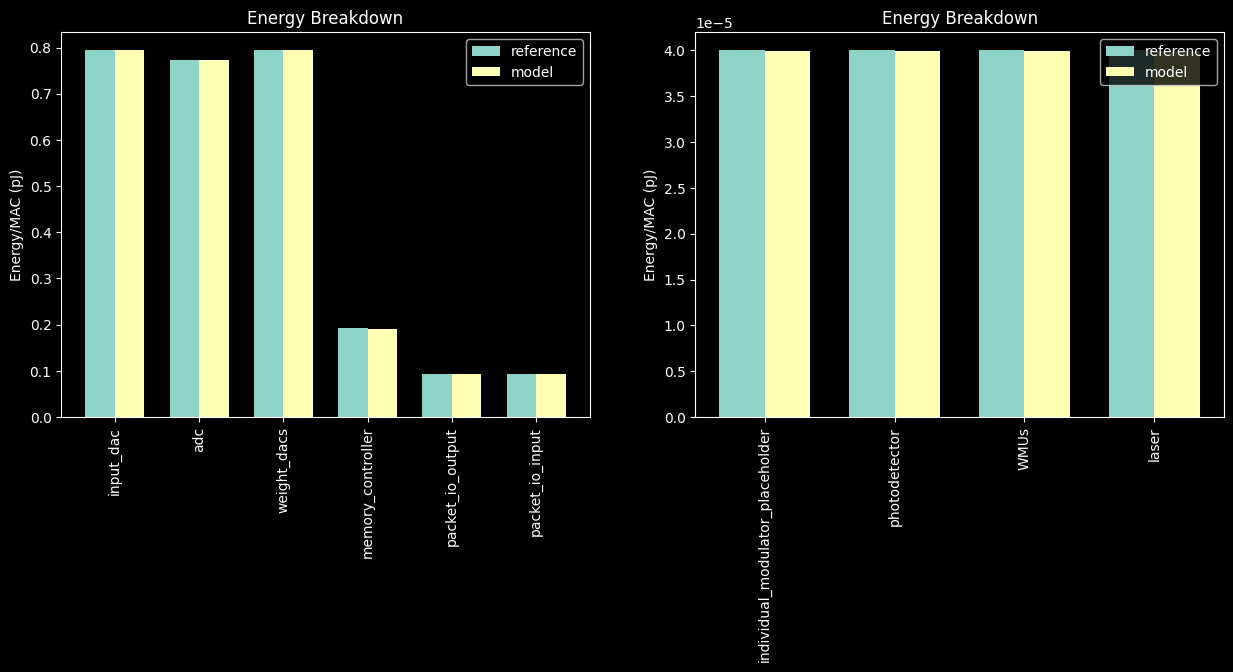

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

big_results = copy.deepcopy(result)
for small_component in ["laser", "WMUs", "photodetector", "individual_modulator_placeholder"]:
    del big_results[0].per_component_energy[small_component]

bar_side_by_side(
    big_results[0].get_compare_ref_energy(),
    xlabel="",
    ylabel="Energy/MAC (pJ)",
    title=f"Energy Breakdown",
    ax=ax[0],
)

small_results = copy.deepcopy(result)
for big_component in ["packet_io_input", "packet_io_output", "memory_controller", "weight_dacs", "adc", "input_dac"]:
    del small_results[0].per_component_energy[big_component]

bar_side_by_side(
    small_results[0].get_compare_ref_energy(),
    xlabel="",
    ylabel="Energy/MAC (pJ)",
    title=f"Energy Breakdown",
    ax=ax[1],
)

In [11]:
display_markdown("# Running DNN Models")
display_markdown("# Alexnet: varying batch size")

# Running DNN Models

# Alexnet: varying batch size


   This test evaluates full-DNN energy efficiency and throughput.
   

100%|██████████| 24/24 [00:15<00:00,  1.59it/s]


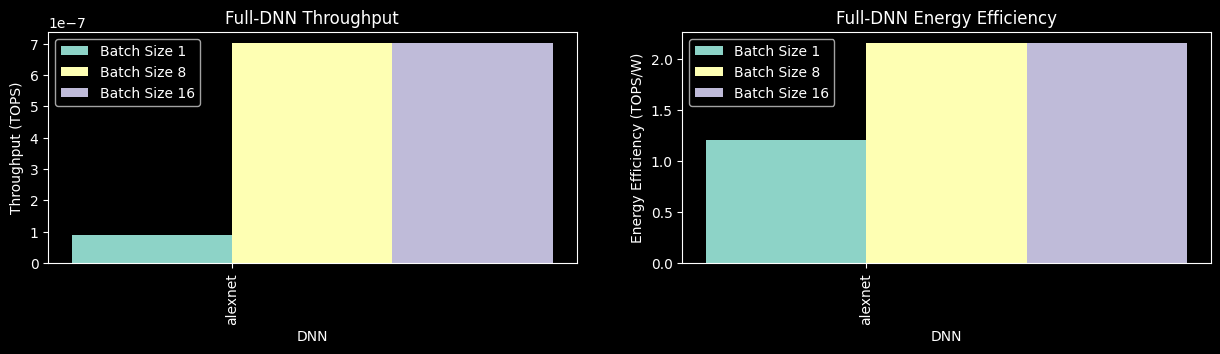

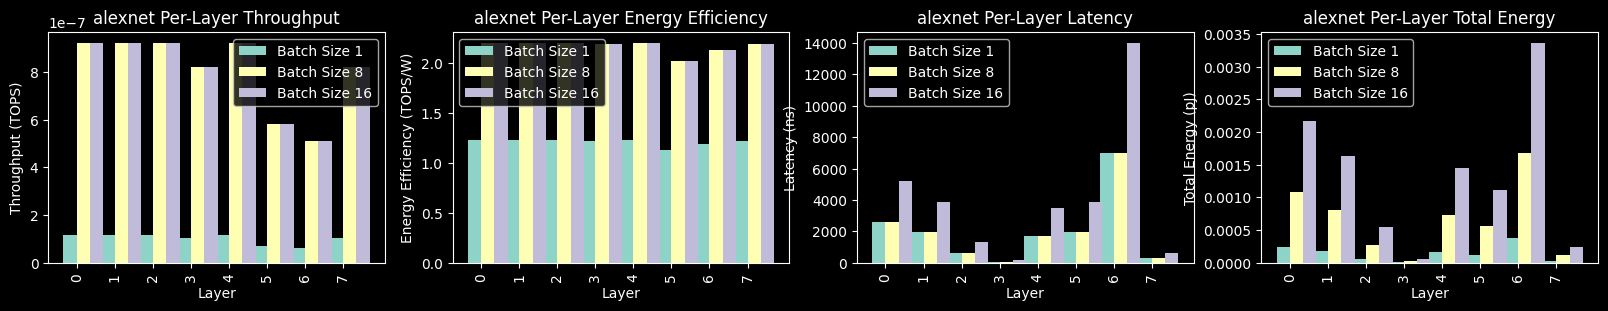

In [12]:
# This test may take a while to run. We have to find a mapping for every layer
# for every DNN being tested.
results = {}
for i, dnn in enumerate(["alexnet"]):
    results[dnn] = run_test(
        "lightning_sigc_2023", 
        "test_full_dnn", 
        dnn_name=dnn, 
        show_doc=(i == 0), 
        batch_sizes=[1, 8, 16],
        num_parallel_wavelengths=[24],
        num_parallel_batches=[8],
        num_parallel_weights=[24]
    )

fig, axs = plt.subplots(1, 2, figsize=(15, 3))

tops, tops_per_w = {}, {}

# Full-DNN results
for dnn, r in results.items():
    tops[dnn], tops_per_w[dnn] = {}, {}
    for r2 in r.aggregate_by("BATCH_SIZE"):
        batch_size = f'Batch Size {r2.variables["BATCH_SIZE"]}'
        tops[dnn][batch_size] = r2.tops
        tops_per_w[dnn][batch_size] = r2.tops_per_w

for ax, data, title, ylabel in [
    (axs[0], tops, "Throughput", "TOPS"),
    (axs[1], tops_per_w, "Energy Efficiency", "TOPS/W"),
]:
    bar_side_by_side(
        data,
        xlabel="DNN",
        ylabel=f"{title} ({ylabel})",
        title=f"Full-DNN {title}",
        ax=ax,
    )

# Per-Layer Results
for dnn, result in results.items():
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    for ax, attrname, title, ylabel in [
        (ax[0], "tops", "Throughput", "TOPS"),
        (ax[1], "tops_per_w", "Energy Efficiency", "TOPS/W"),
        (ax[2], "latency", "Latency", "ns"),
        (ax[3], "energy", "Total Energy", "pJ"),
    ]:
        per_layer_results = {}
        for j, same_layers in enumerate(zip(*result.split_by("BATCH_SIZE"))):
            per_layer_results[j] = {
                f'Batch Size {r.variables["BATCH_SIZE"]}': getattr(r, attrname)
                for r in same_layers
            }
        bar_side_by_side(
            per_layer_results,
            xlabel="Layer",
            ylabel=f"{title} ({ylabel})",
            title=f"{dnn} Per-Layer {title}",
            ax=ax,
        )

In [13]:
display_markdown("# Resnet")
display_markdown("# Resnet: varying batch size")

# Resnet

# Resnet: varying batch size


   This test evaluates full-DNN energy efficiency and throughput.
   

100%|██████████| 63/63 [00:38<00:00,  1.65it/s]


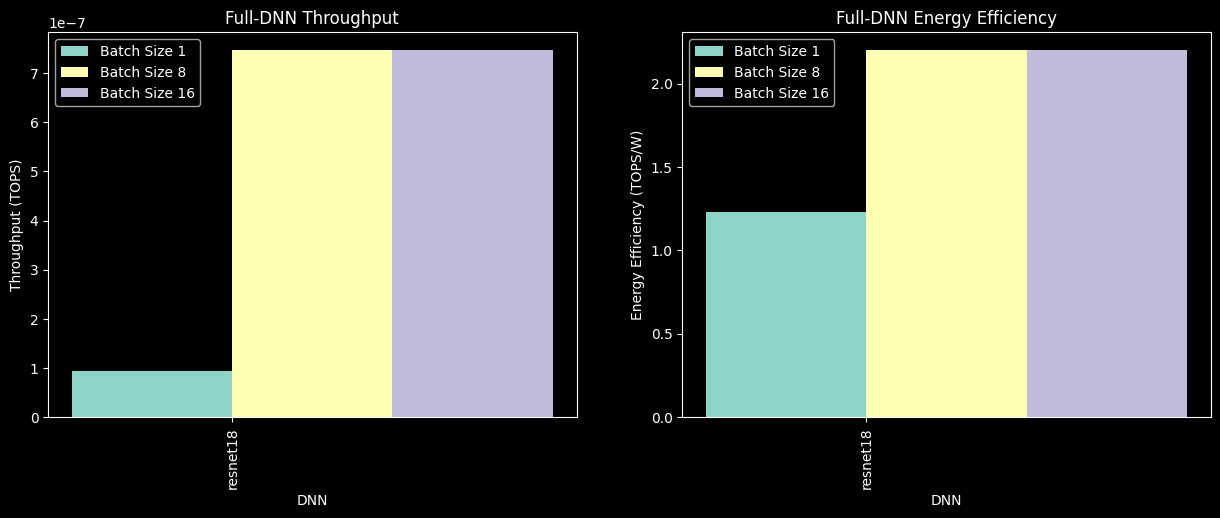

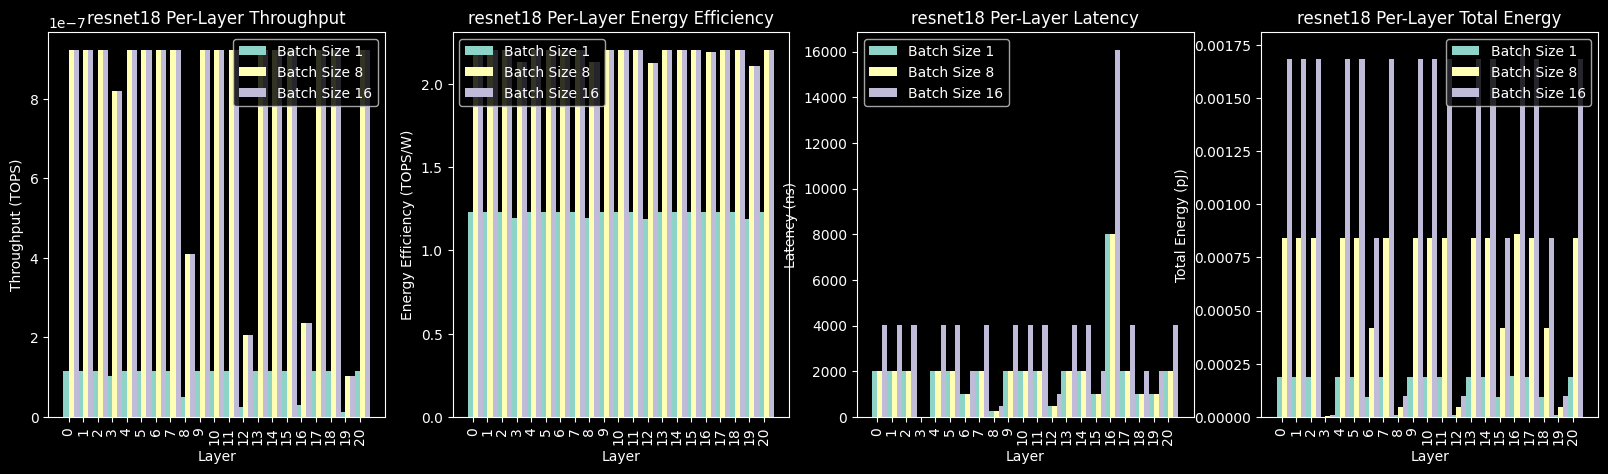

In [14]:
# This test may take a while to run. We have to find a mapping for every layer
# for every DNN being tested.
results = {}
for i, dnn in enumerate(["resnet18"]):
    results[dnn] = run_test(
        "lightning_sigc_2023",
        "test_full_dnn", 
        dnn_name=dnn, 
        show_doc=i == 0, 
        batch_sizes=[1, 8, 16],
        num_parallel_wavelengths=[24],
        num_parallel_batches=[8],
        num_parallel_weights=[24]
    )

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

tops, tops_per_w = {}, {}

# Full-DNN results
for dnn, r in results.items():
    tops[dnn], tops_per_w[dnn] = {}, {}
    for r2 in r.aggregate_by("BATCH_SIZE"):
        batch_size = f'Batch Size {r2.variables["BATCH_SIZE"]}'
        tops[dnn][batch_size] = r2.tops
        tops_per_w[dnn][batch_size] = r2.tops_per_w

for ax, data, title, ylabel in [
    (axs[0], tops, "Throughput", "TOPS"),
    (axs[1], tops_per_w, "Energy Efficiency", "TOPS/W"),
]:
    bar_side_by_side(
        data,
        xlabel="DNN",
        ylabel=f"{title} ({ylabel})",
        title=f"Full-DNN {title}",
        ax=ax,
    )

# Per-Layer Results
for dnn, result in results.items():
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    for ax, attrname, title, ylabel in [
        (ax[0], "tops", "Throughput", "TOPS"),
        (ax[1], "tops_per_w", "Energy Efficiency", "TOPS/W"),
        (ax[2], "latency", "Latency", "ns"),
        (ax[3], "energy", "Total Energy", "pJ"),
    ]:
        per_layer_results = {}
        for j, same_layers in enumerate(zip(*result.split_by("BATCH_SIZE"))):
            per_layer_results[j] = {
                f'Batch Size {r.variables["BATCH_SIZE"]}': getattr(r, attrname)
                for r in same_layers
            }
        bar_side_by_side(
            per_layer_results,
            xlabel="Layer",
            ylabel=f"{title} ({ylabel})",
            title=f"{dnn} Per-Layer {title}",
            ax=ax,
        )

In [15]:
display_markdown('''
# Experiment 1: DNN Comparison:
### alexnet, vgg16, resnet18; varying batch size
''')


# Experiment 1: DNN Comparison:
### alexnet, vgg16, resnet18; varying batch size


In [16]:
# This test may take a while to run. We have to find a mapping for every layer
# for every DNN being tested.
results = {}
for i, dnn in enumerate(["alexnet", "vgg16", "resnet18"]):
    results[dnn] = run_test(
        "lightning_sigc_2023", "test_full_dnn", dnn_name=dnn, show_doc=i == 0, batch_sizes=[1, 8], num_parallel_wavelengths=[24], num_parallel_batches=[8], num_parallel_weights=[24]
    )


   This test evaluates full-DNN energy efficiency and throughput.
   

100%|██████████| 42/42 [00:22<00:00,  1.88it/s]


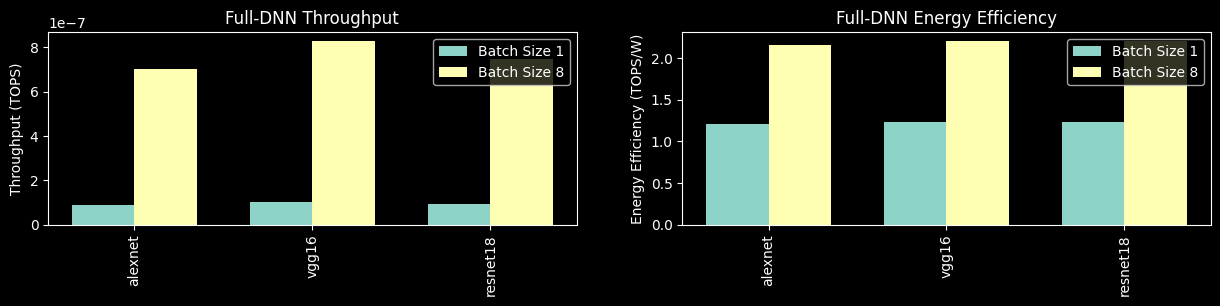

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 2.5))

tops, tops_per_w = {}, {}

# Full-DNN results
for dnn, r in results.items():
    tops[dnn], tops_per_w[dnn] = {}, {}
    for r2 in r.aggregate_by("BATCH_SIZE"):
        batch_size = f'Batch Size {r2.variables["BATCH_SIZE"]}'
        tops[dnn][batch_size] = r2.tops
        tops_per_w[dnn][batch_size] = r2.tops_per_w

for ax, data, title, ylabel in [
    (axs[0], tops, "Throughput", "TOPS"),
    (axs[1], tops_per_w, "Energy Efficiency", "TOPS/W"),
]:
    bar_side_by_side(
        data,
        xlabel="",
        ylabel=f"{title} ({ylabel})",
        title=f"Full-DNN {title}",
        ax=ax,
    )

In [18]:
display_markdown("# Experiment 2: Latency")

# Experiment 2: Latency


   This test evaluates full-DNN energy efficiency and throughput.
   

100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


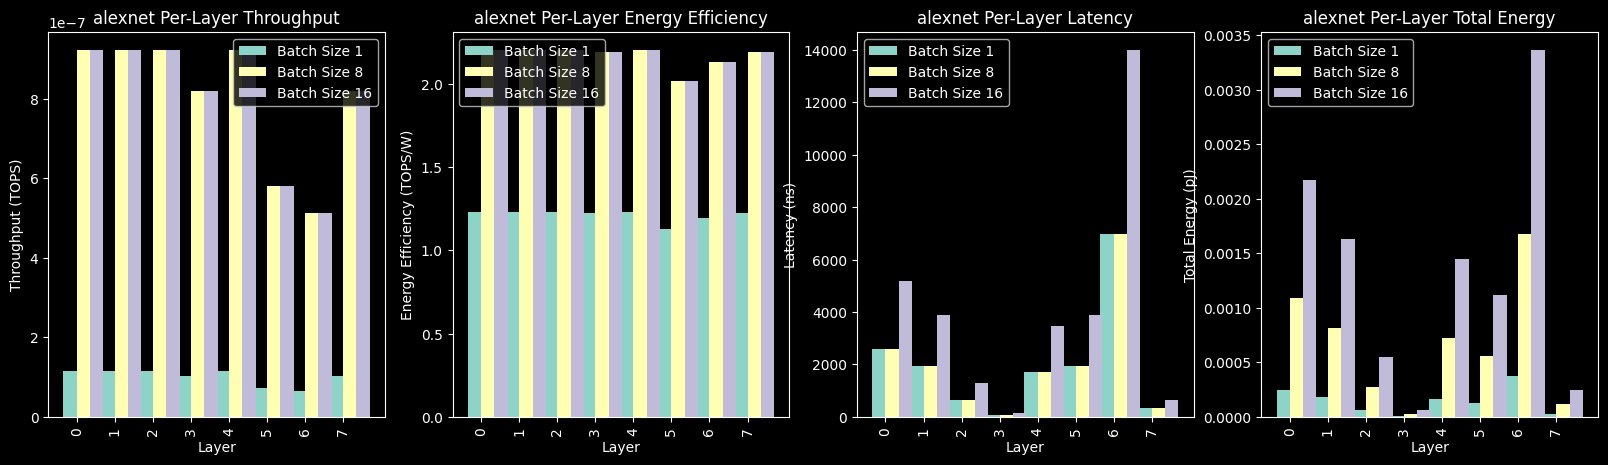

In [19]:
# This test may take a while to run. We have to find a mapping for every layer
# for every DNN being tested.
results = {}
for i, dnn in enumerate(["alexnet"]):
    results[dnn] = run_test(
        "lightning_sigc_2023", 
        "test_full_dnn", 
        dnn_name=dnn, 
        show_doc=(i == 0),
        batch_sizes=[1, 8, 16],
        num_parallel_wavelengths=[24],
        num_parallel_batches=[8],
        num_parallel_weights=[24]
    )

# Per-Layer Results
for dnn, result in results.items():
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    for ax, attrname, title, ylabel in [
        (ax[0], "tops", "Throughput", "TOPS"),
        (ax[1], "tops_per_w", "Energy Efficiency", "TOPS/W"),
        (ax[2], "latency", "Latency", "ns"),
        (ax[3], "energy", "Total Energy", "pJ"),
    ]:
        per_layer_results = {}
        for j, same_layers in enumerate(zip(*result.split_by("BATCH_SIZE"))):
            per_layer_results[j] = {
                f'Batch Size {r.variables["BATCH_SIZE"]}': getattr(r, attrname)
                for r in same_layers
            }
        bar_side_by_side(
            per_layer_results,
            xlabel="Layer",
            ylabel=f"{title} ({ylabel})",
            title=f"{dnn} Per-Layer {title}",
            ax=ax,
        )

In [20]:
display_markdown("# Experiment 3: Throughput vs Number Of Wavelengths")


# Experiment 3: Throughput vs Number Of Wavelengths

In [21]:
# This test may take a while to run. We have to find a mapping for every layer
# for every DNN being tested.
results = {}
for i, dnn in enumerate(["alexnet"]):
    results[dnn] = run_test(
        "lightning_sigc_2023", 
        "test_full_dnn", 
        dnn_name=dnn, 
        show_doc=(i == 0),
        batch_sizes=[8],
        num_parallel_wavelengths=[24, 12, 4],
        num_parallel_batches=[8],
        num_parallel_weights=[8]
    )


   This test evaluates full-DNN energy efficiency and throughput.
   

100%|██████████| 24/24 [00:51<00:00,  2.16s/it]


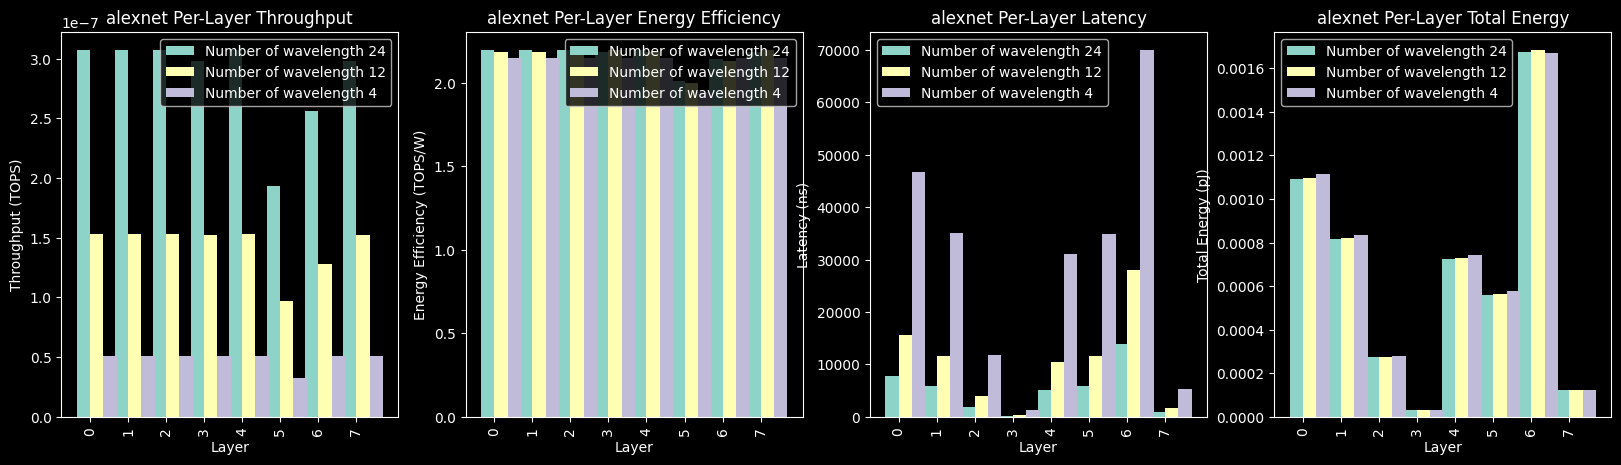

In [22]:
# Per-Layer Results
for dnn, result in results.items():
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    for ax, attrname, title, ylabel in [
        (ax[0], "tops", "Throughput", "TOPS"),
        (ax[1], "tops_per_w", "Energy Efficiency", "TOPS/W"),
        (ax[2], "latency", "Latency", "ns"),
        (ax[3], "energy", "Total Energy", "pJ"),
    ]:
        per_layer_results = {}
        for j, same_layers in enumerate(zip(*result.split_by("NUM_WAVELENGTHS"))):
            per_layer_results[j] = {
                f'Number of wavelength {r.variables["NUM_WAVELENGTHS"]}': getattr(r, attrname)
                for r in same_layers
            }
        bar_side_by_side(
            per_layer_results,
            xlabel="Layer",
            ylabel=f"{title} ({ylabel})",
            title=f"{dnn} Per-Layer {title}",
            ax=ax,
        )

In [23]:
display_markdown("# Experiment 4: Throughput vs Number Of Parallel Weights")

# Experiment 4: Throughput vs Number Of Parallel Weights

In [24]:
# This test may take a while to run. We have to find a mapping for every layer
# for every DNN being tested.
results = {}
for i, dnn in enumerate(["alexnet"]):
    results[dnn] = run_test(
        "lightning_sigc_2023", 
        "test_full_dnn",
        dnn_name=dnn, 
        show_doc=(i == 0),
        batch_sizes=[8],
        num_parallel_wavelengths=[24],
        num_parallel_batches=[8],
        num_parallel_weights=[1, 8, 24]
    )


   This test evaluates full-DNN energy efficiency and throughput.
   

100%|██████████| 24/24 [00:41<00:00,  1.74s/it]


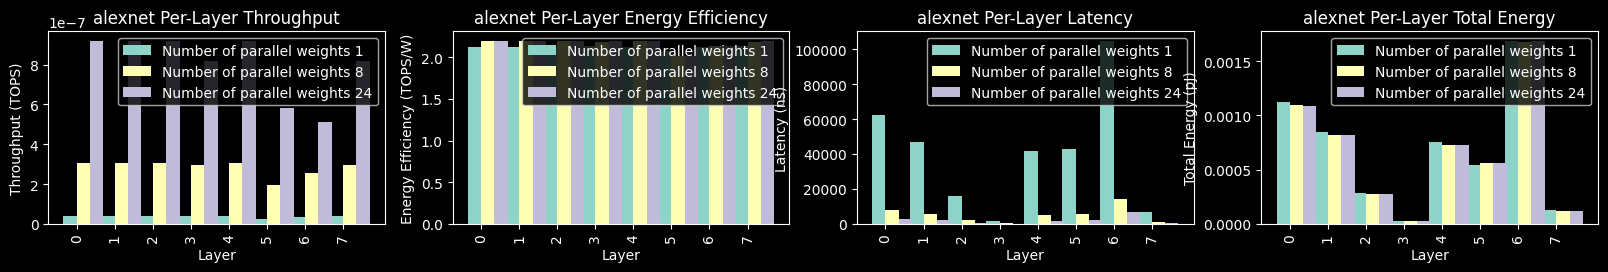

In [25]:
# Per-Layer Results
for dnn, result in results.items():
    fig, ax = plt.subplots(1, 4, figsize=(20, 2.5))
    for ax, attrname, title, ylabel in [
        (ax[0], "tops", "Throughput", "TOPS"),
        (ax[1], "tops_per_w", "Energy Efficiency", "TOPS/W"),
        (ax[2], "latency", "Latency", "ns"),
        (ax[3], "energy", "Total Energy", "pJ"),
    ]:
        per_layer_results = {}
        for j, same_layers in enumerate(zip(*result.split_by("NUM_PARALLEL_WEIGHTS"))):
            per_layer_results[j] = {
                f'Number of parallel weights {r.variables["NUM_PARALLEL_WEIGHTS"]}': getattr(r, attrname)
                for r in same_layers
            }
        bar_side_by_side(
            per_layer_results,
            xlabel="Layer",
            ylabel=f"{title} ({ylabel})",
            title=f"{dnn} Per-Layer {title}",
            ax=ax,
        )